## Plot the clustering different between splits

In [95]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import random
import numpy as np
from pathlib import Path
import lsstypes as types
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from astropy.table import Table,join,Column

SAVE_DIR = '/global/homes/s/shengyu/Y3/blinded_data_splits/main/results'

In [98]:
sys.path.append('../')
from helper import REDSHIFT_BIN_LSS, get_namespace
%load_ext autoreload
%autoreload 2
%matplotlib inline


def load_bins(corr_type, bins_type = 'test'):
    if corr_type == 'xi':
        if bins_type in ['test']:
            rmin, rmax, rbin, lenr = 20, 200, 4, 45
        elif bins_type in ['y3_bao', 'y3_sys']:
            rmin, rmax, rbin, lenr = 60, 150, 4, 23
        else:
            raise ValueError(f"Unknown bins_type '{bins_type}' for correlation type 'xi'.")
        return (rmin, rmax, rbin, lenr)
    elif corr_type == 'pk':
        if bins_type in ['y3_bao', 'test']:
            kmin, kmax, kbin, lenk = 0.02, 0.3, 0.005, 56
        elif bins_type in ['y3_fs', 'y3_sys', 'y3_blinding']: 
            kmin, kmax, kbin, lenk = 0.02, 0.2, 0.005, 36
        elif bins_type in ['test_covbox']:
            kmin, kmax, kbin, lenk = 0.03, 0.2, 0.005, 34     
        else:
            raise ValueError(f"Unknown bins_type '{bins_type}' for correlation type 'pk'.")
        return (kmin, kmax, kbin, lenk)
    elif corr_type == 'bk':
        if bins_type in ['test']:
            kmin, kmax, kbin, lenk = 0, 0.2, 0.01, 20 #Sigiyama space
        else:
            raise ValueError(f"Unknown bins_type '{bins_type}' for correlation type 'bk'.")
        return (kmin, kmax, kbin, lenk)
    else:
        raise ValueError(f"Invalid corr_type '{corr_type}'. Expected one of ['xi', 'pk', 'mpslog', 'wp', 'bk'].")
    

def get_measurement_fn(kind='mesh2_spectrum_poles', version='dr2-v2', recon=None, tracer='LRG', region='NGC', zrange=(0.8, 1.1), cut=None, auw=None, nran = 18, weight_type='default', **kwargs):
    # base_dir = Path(f'/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/')
    # base_dir = base_dir / (f'blinded_{recon}' if recon else 'blinded')
    base_dir = Path(f'/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/{version}/data_splits')
    if 'window' in kind or 'covariance' in kind:
        base_dir = Path(f'/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/unblinded_data/{version}')
        if cut: cut = '_thetacut'
        else: cut = ''
        if auw: auw = '_auw'
        else: auw = ''
        return str(base_dir / f'{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}{auw}{cut}.h5')
    else:
        if cut: cut = '_thetacut'
        else: cut = ''
        if auw: auw = '_auw'
        else: auw = ''
        return str(base_dir / f'{kind}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}{auw}{cut}_nran{nran}.h5')

def load_blinded_data_pip(args, ells = (0,2), bins_type = 'y3_blinding', blinding=True, dir = None):
    if dir == None:
        DIR = '/pscratch/sd/s/shengyu/Y3/blinded/test'
    """
    Dispatch to the blinded data files, window function and covariance based on `args`.

    Parameters
    ----------
    args : dict
    corr_type : {'pk': 'y3_blinding'}
    bins_type : any, optional --> load_bins function

    Returns
    -------
    data, wmatrix, covariance
    """
    (kmin, kmax, kbin, lenk) = load_bins('pk', bins_type)
    prefix='blinded_' if blinding == True else ''
    data = types.read(get_measurement_fn(**args, kind=f'{prefix}mesh2_spectrum_poles'))
    window = types.read(get_measurement_fn(**args, kind=f'window_mesh2_spectrum_poles'))
    covariance = types.read(get_measurement_fn(**args, kind=f'covariance_mesh2_spectrum_poles'))
    ells = list(ells)
    sl = slice(0, None, 5)  # rebin to dk = 0.005 h/Mpc
    oklim = (kmin, kmax)  # fitted k-range, no need to go to higher k
    mean = data.select(k=sl).select(k=oklim).get(ells)
    wmatrix = window.at.observable.match(mean).at.theory.match(data.select(k=(0., 1.1 * oklim[1])).get(ells))
    covariance = covariance.at.observable.match(mean)
    return mean, wmatrix, covariance


def load_mesh2_spectrum_poles(data_fn, ells = (0,2), bins_type = 'y3_blinding'):
    (kmin, kmax, kbin, lenk) = load_bins('pk', bins_type)
    data = types.read(data_fn)
    ells = list(ells)
    sl = slice(0, None, 5)  # rebin to dk = 0.005 h/Mpc
    oklim = (kmin, kmax)  # fitted k-range, no need to go to higher k
    data = data.select(k=sl).select(k=oklim).get(ells)
    k = data.get(ells=0).coords('k')
    Pk = {ell: data.get(ells=ell).values() for ell in data.ells}
    return k, Pk 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


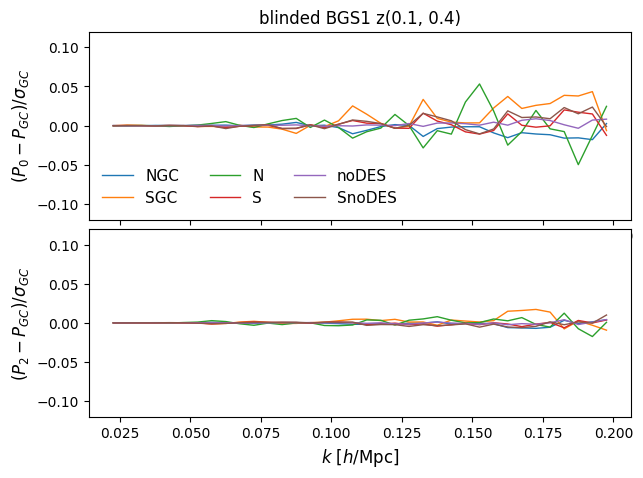

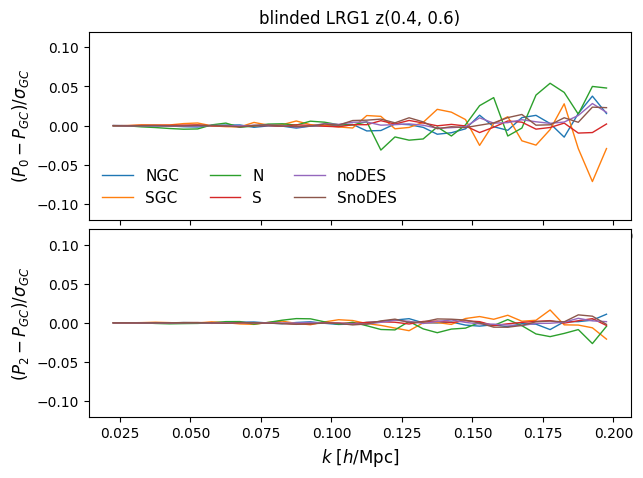

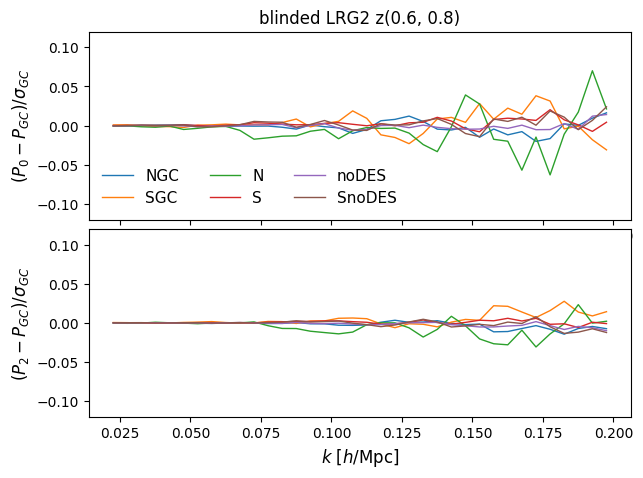

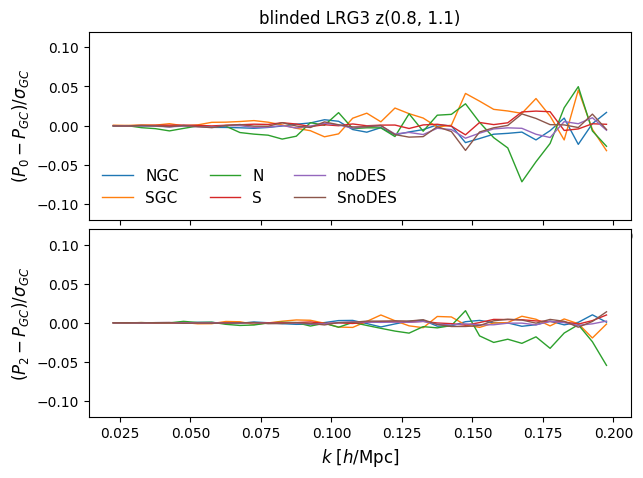

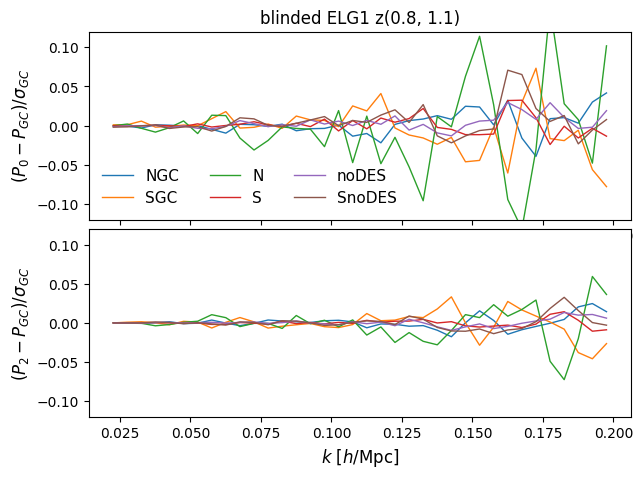

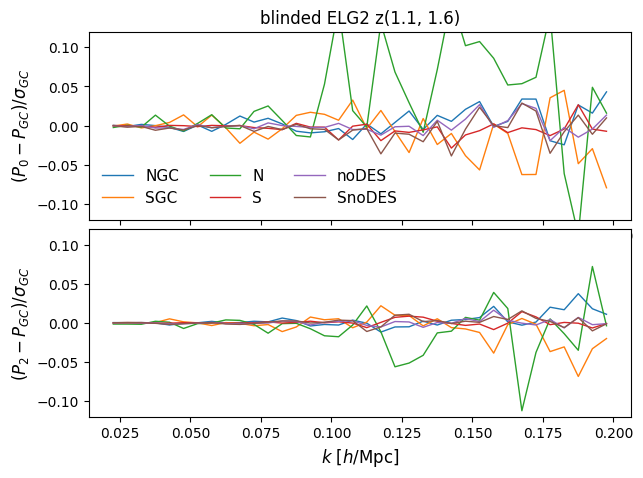

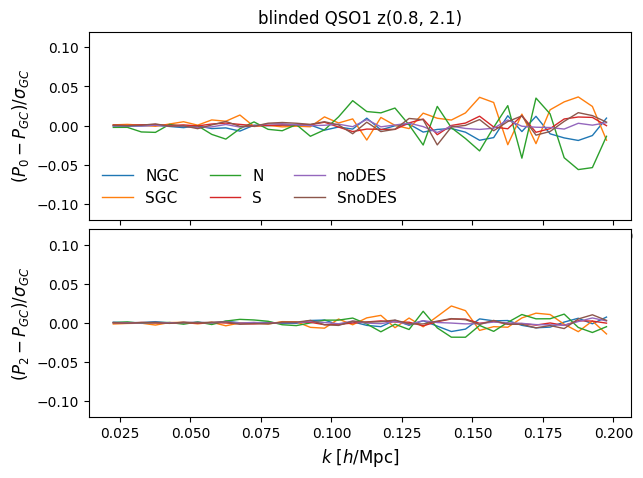

In [103]:
version = 'dr2-v2'

default_bin = [
('BGS', (0.1, 0.4)),
('LRG', (0.4, 0.6)),
('LRG', (0.6, 0.8)),
('LRG', (0.8, 1.1)),
('ELG_LOPnotqso', (0.8, 1.1)),
('ELG_LOPnotqso', (1.1, 1.6)),
('QSO', (0.8, 2.1))
]
regions = ['NGC', 'SGC', 'N', 'S', 'noDES', 'SnoDES']

for (tracer, zrange) in default_bin:
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    catalog_args = dict(version=version, region='GCcomb', tracer=tracer, zrange=zrange, weight_type='default_fkp', nran=18)

    mean, _, covariance = load_blinded_data_pip(catalog_args)
    std = np.diag(covariance.value())

    mean = {ell: mean.get(ells=ell).values() for ell in mean.ells}
    std = {0:std[:36], 2: std[36:]}

    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 1, wspace=0., hspace=0.05, height_ratios=[1, 1])
    title = f'{get_namespace(tracer, zrange)}'
    for region in regions:
        catalog_args['region'] = region
        fn = get_measurement_fn(kind='blinded_mesh2_spectrum_poles', **catalog_args)
        k, Pk = load_mesh2_spectrum_poles(fn)
        for ell in [0,2]:
            ax = plt.subplot(gs[int(ell/2)])
            label = f'{region}' if ell ==0 else None 
            # plt.plot(k,k*Pk[ell]['value'], label = label, lw=1)
            ax.plot(k,(Pk[ell]['value']-mean[ell]['value'])/std[ell], label = label, lw=1)
            # ax.set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{GC P_{{{0:d}}} }}$'.format(ell), fontsize=12)
            ax.set_ylabel(r'$(P_{{{0:d}}}- P_{{GC}}) / \sigma_{{GC}}$'.format(ell), fontsize=12)
            # for offset in [-0.1, 0.1]:
            #     ax.axhline(offset, color='k', linestyle='--')
            ax.set_ylim([-0.12, 0.12])
            if ell == 0:
                ax.legend(loc=3, ncols = 3, frameon=False, fontsize=11)
                ax.set_title(f'blinded {title} z{zrange}')
            if ell == 2:
                ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize=12)            
    fig.savefig(SAVE_DIR+f'/plots/clustering_{title}_allcompare.png')

Mesh2SpectrumPoles(labels=[{'ells': 0}, {'ells': 2}], size=72)

In [59]:
Pk[ell]['value']

array([ -905.37702133,  8262.77156829, 13524.43355556, 24623.67422706,
       29745.4150413 , 39873.13649015, 45113.09962306, 54699.23056793,
       53738.54864694, 57639.13515493, 57688.76925753, 60518.02506897,
       63221.07793686, 61715.80595888, 61715.24310936, 59293.60299662,
       60000.85874289, 57549.76692543, 53775.14929115, 52477.92671903,
       48347.0893113 , 50132.57153574, 54666.71420615, 56877.09659205,
       54460.69470818, 48773.68239438, 44205.3807127 , 40732.71915164,
       40844.59875592, 41380.99966423, 42310.94735466, 39656.78221792,
       39053.00890483, 36850.84817588, 35700.37220994, 37234.58270317,
       36374.37692953, 36651.05135395, 35435.13280933, 34227.02001406,
       33014.58120607, 31818.0526547 , 31499.43274734, 30988.64835487,
       29770.37990495, 28866.0691008 , 28175.25345734, 27818.45261428,
       27955.0621599 , 28651.26546341, 29100.32136506, 28350.83211392,
       28112.96437535, 27783.62838496, 27637.16222327, 26644.45259534,
      

In [30]:
len(np.diag(covariance.value()))

72

In [ ]:
covariance.get

{'value': array([34929.62674975, 33832.98653202, 29796.12161378, 27789.54133311,
        22901.76647163, 20986.21185534, 20282.39841692, 19253.93799168,
        17227.94814767, 16237.4434584 , 15060.93880767, 13799.66722537,
        12642.08549381, 11490.06572195, 10600.1339779 ,  9226.27923037,
         8614.62926162,  8000.33764281,  7541.79480277,  7098.04052677,
         6788.77498382,  6520.43000351,  6093.56121416,  5618.03470678,
         5396.32536517,  5250.0691639 ,  4681.1953422 ,  4333.05891749,
         4217.86721936,  3963.51510107,  3622.7419004 ,  3360.67045191,
         3483.64809162,  3310.04250465,  3162.73975128,  2834.94596432]),
 'num_shotnoise': array([1118575.36708462, 1118575.36708462, 1118575.36708462,
        1118575.36708462, 1118575.36708462, 1118575.36708462,
        1118575.36708462, 1118575.36708462, 1118575.36708462,
        1118575.36708462, 1118575.36708462, 1118575.36708462,
        1118575.36708462, 1118575.36708462, 1118575.36708462,
        111857

/pscratch/sd/s/shengyu/Y3/blinded/dr1-v1.5/data_splits/mesh2_spectrum_poles_QSO_z0.8-2.1_SGC_default_fkp_nran18_o.h5
/pscratch/sd/s/shengyu/Y3/blinded/dr1-v1.5/data_splits/mesh2_spectrum_poles_QSO_z0.8-2.1_SGC_default_fkp_nran18_o_mb.h5
/pscratch/sd/s/shengyu/Y3/blinded/dr1-v1.5/data_splits/mesh2_spectrum_poles_QSO_z0.8-2.1_SGC_default_fkp_nran18_mpi_block.h5


Text(0, 0.5, 'SGC Pk0')

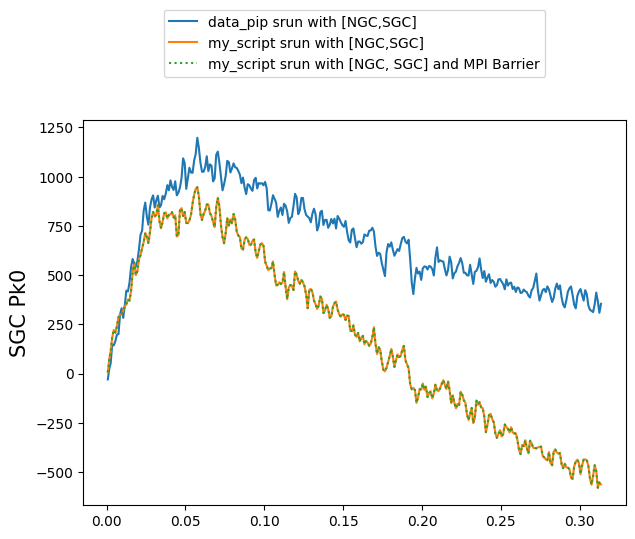

In [ ]:
version = 'dr1-v1.5'

fig = plt.figure(figsize=(7, 5))
for tracer in ['QSO']:
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    for zrange in REDSHIFT_BIN_LSS[tracer[:3]]:
        for i, region in enumerate(['SGC']):
            data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp', 'version':version}
            fn = f'/pscratch/sd/s/shengyu/Y3/blinded/dr1-v1.5/data_splits/mesh2_spectrum_poles_QSO_z0.8-2.1_SGC_default_fkp_nran18_o.h5'
            print(fn)
            k, Pk = load_mesh2_spectrum_poles(fn)
            for ell in [0]:
                plt.plot(k,k*Pk[ell]['value'], label = 'data_pip srun with [NGC,SGC]', color = 'C0')

for tracer in ['QSO']:
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    for zrange in REDSHIFT_BIN_LSS[tracer[:3]]:
        for i, region in enumerate(['SGC']):
            data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp', 'version':version}
            fn = f'/pscratch/sd/s/shengyu/Y3/blinded/dr1-v1.5/data_splits/mesh2_spectrum_poles_QSO_z0.8-2.1_SGC_default_fkp_nran18_o_mb.h5'
            print(fn)
            k, Pk = load_mesh2_spectrum_poles(fn)
            for ell in [0]:
                plt.plot(k,k*Pk[ell]['value'], label = 'my_script srun with [NGC,SGC]', color = f'C1')

for tracer in ['QSO']:
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    for zrange in REDSHIFT_BIN_LSS[tracer[:3]]:
        for i, region in enumerate(['SGC']):
            data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp', 'version':version}
            fn = f'/pscratch/sd/s/shengyu/Y3/blinded/dr1-v1.5/data_splits/mesh2_spectrum_poles_QSO_z0.8-2.1_SGC_default_fkp_nran18_mpi_block.h5'
            print(fn)
            k, Pk = load_mesh2_spectrum_poles(fn)
            for ell in [0]:
                plt.plot(k,k*Pk[ell]['value'], label = 'my_script srun with [NGC, SGC] and MPI Barrier', color = f'C2', ls = ':')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.2))
plt.ylabel('SGC Pk0', fontsize = 15)

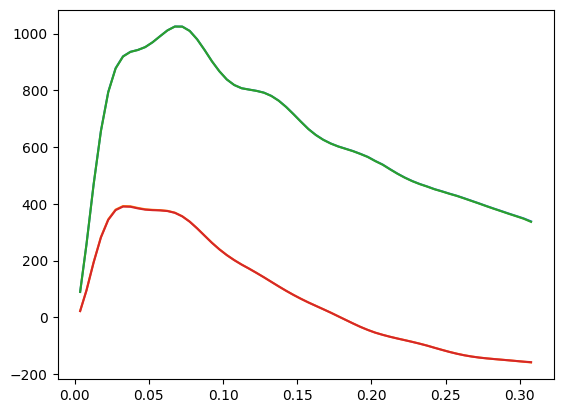

In [68]:
dir = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/unblinded_data/dr2-v2'
NGC_fn = dir+'/covariance_mesh2_spectrum_poles_QSO_z0.8-2.1_NGC_default_fkp.h5'
# k, Pk = load_mesh2_spectrum_poles(NGC_fn)
covariance = types.read(NGC_fn)
result = covariance.observable.select(k=slice(0, None, 5))
k = result.get(ells=0).coords('k')
Pk = {ell: result.get(ells=ell).values() for ell in result.ells}

for ell in [0,2]:
    plt.plot(k,k*Pk[ell]['value'])

dir = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/unblinded_data/dr2-v2'
SGC_fn = dir+'/covariance_mesh2_spectrum_poles_QSO_z0.8-2.1_SGC_default_fkp.h5'
# k, Pk = load_mesh2_spectrum_poles(NGC_fn)
covariance = types.read(SGC_fn)
result = covariance.observable.select(k=slice(0, None, 5))
k = result.get(ells=0).coords('k')
Pk = {ell: result.get(ells=ell).values() for ell in result.ells}

for ell in [0,2]:
    plt.plot(k,k*Pk[ell]['value'])

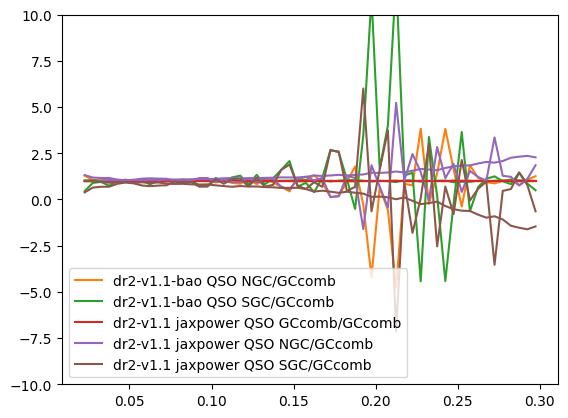

In [31]:
version = 'dr2-v1.1'
dir = '/global/cfs/cdirs/desi/survey/catalogs/DA2/analysis/loa-v1/LSScats/v1.1/BAO/unblinded/desipipe/2pt/pk/'

for i, region in enumerate(['GCcomb', 'NGC', 'SGC']):
    pkpoles_fn = dir+f'pkpoles_QSO_{region}_z0.8-2.1_default_SYS1_FKP_lin_nran18_cellsize6_boxsize10000.npy'
    result = PowerSpectrumMultipoles.load(pkpoles_fn)
    result = result.select((0.02,0.3,0.005))
    pk = np.real(result.get_power())
    k = result.kavg
    if region == 'GCcomb':
        fid_pk = pk
    else:
        for ill in [0,1]:
            label = f'dr2-v1.1-bao {tracer} {region}/GCcomb' if ill==0 else None 
            plt.plot(k, pk[ill]/fid_pk[ill], label = label, color = f'C{i}')
        plt.legend()
for i, region in enumerate(['GCcomb', 'NGC', 'SGC']):
    data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp', 'version':version}
    fn = get_measurement_fn(**data_args, kind = 'mesh2_spectrum_poles')
    k, pk = load_mesh2_spectrum_poles(fn)
    if region == 'GCcomb':
        fid_pk = pk
    for ell in [0,2]:
        label = f'{version} jaxpower {tracer} {region}/GCcomb' if ell ==0 else None 
        plt.plot(k, pk[ell]['value']/fid_pk[ell]['value'] ,label = label, color = f'C{i+3}')
    plt.legend()
    plt.ylim([-10,10])